I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from pre_ml_functions import *

# Specify global path
global_path = '/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('All', 'Bona'), value='Bona')

II. Data Preparation

In [3]:
# Set ID
set_id = set_widget.value
# Create region filtered files 
region_filter_fun(global_path,set_id)
# Create eventfile table
create_eventfilestable_fun(global_path,set_id)
# Combine all property tables with each other
dfp_list =[]
for prop_filename in glob.iglob(f'{global_path}/{set_id}/properties-{set_id}-*.csv'):
   dfp = pd.read_csv(prop_filename)
   dfp_list.append(dfp)
df_properties = pd.concat(dfp_list)
df_properties.to_csv(f'{global_path}/{set_id}/properties-{set_id}.csv',index=False)

# Reduce data for useful input to data representation
df_eventfiles = pd.read_csv(f'{global_path}/{set_id}/eventfiles-{set_id}.csv')
df_properties = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_eventfiles_input, df_properties_input = data_reduction_fun(df_eventfiles, df_properties,global_path,set_id)



/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf14927_000N021_e2_r0312_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf13833_000N021_e2_r0384_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf00310_000N021_r0293_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf12160_001N021_e2_r0384_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/Bona/eventdata/acisf08193_000N021_e2_r0398_regevt3_filtered.fits.gz already exists!
/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-CfA/4-Data/Datasets/B

III. Show Bona-fide Examples

In [3]:
from matplotlib.colors import LogNorm
from sherpa.astro import ui
# Set ID
set_id = set_widget.value

df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')

df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)

print("ObsID and RegID: ", df_eventfiles_group.groups.keys())

Number of Eventfiles:  17
Number of Property Sets:  17
ObsID and RegID:  dict_keys(['10822_185', '10921_3', '10969_216', '10995_21', '10996_27', '10996_5', '11013_34', '11104_129', '13682_9', '13814_176', '13814_567', '14436_54', '14538_5', '2833_53', '2896_129', '9109_333', '9109_344'])


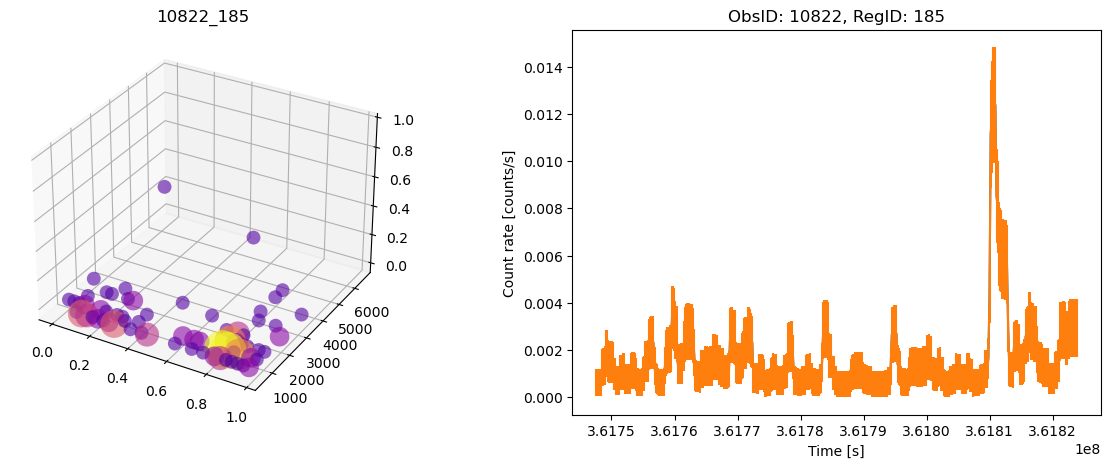

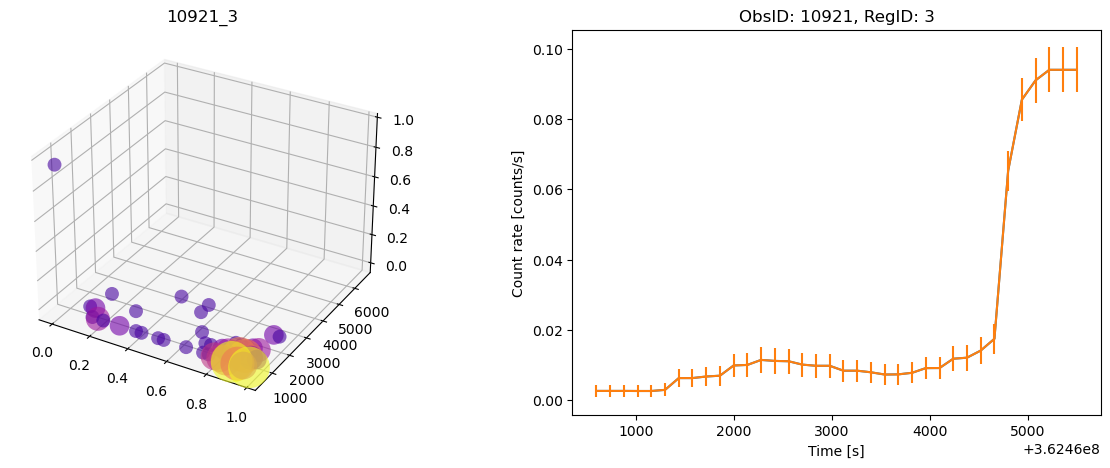

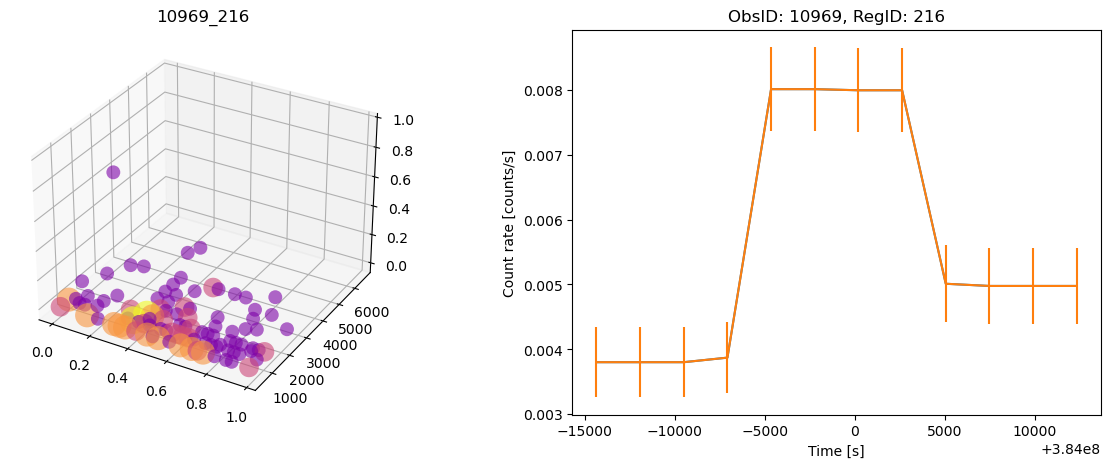

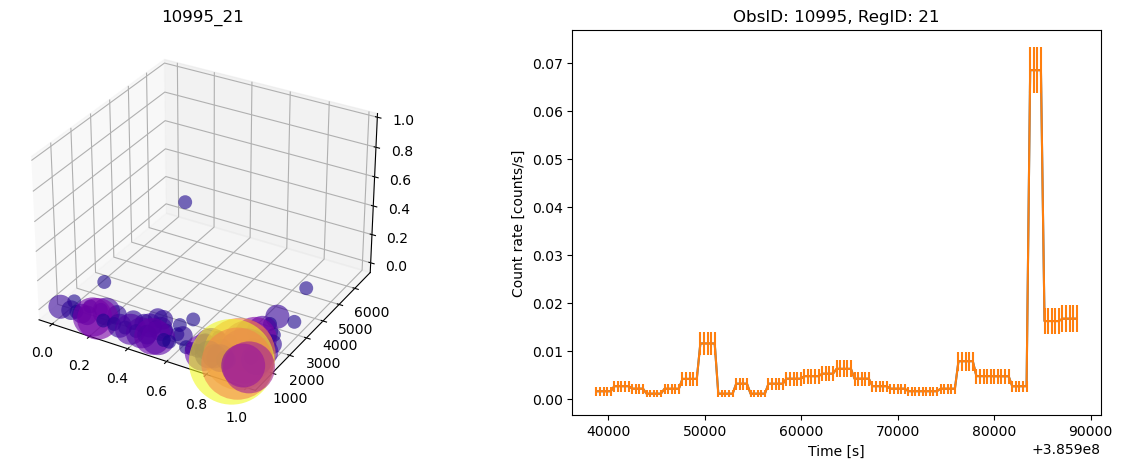

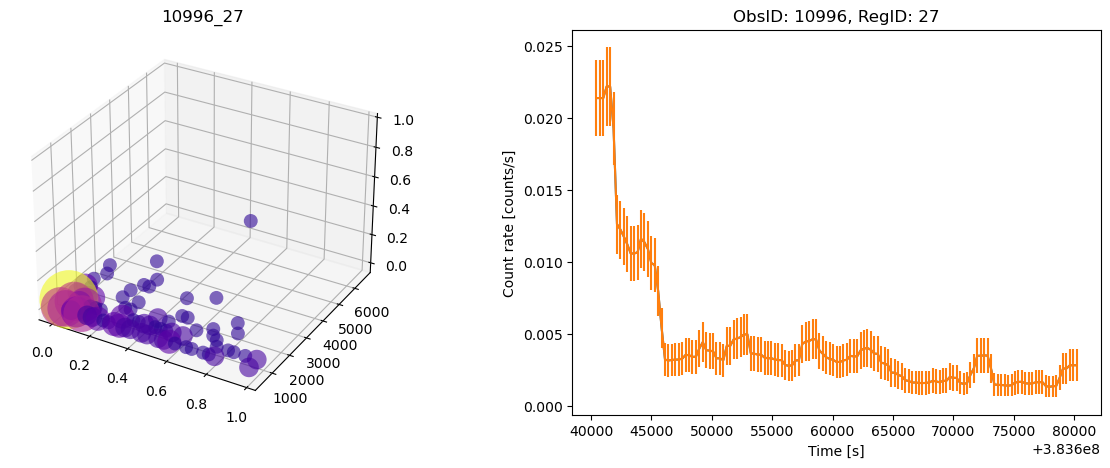

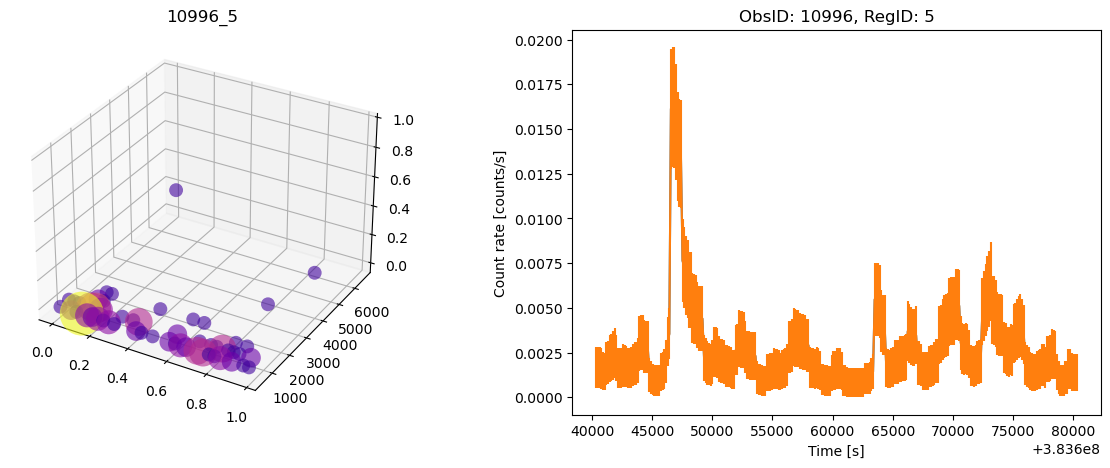

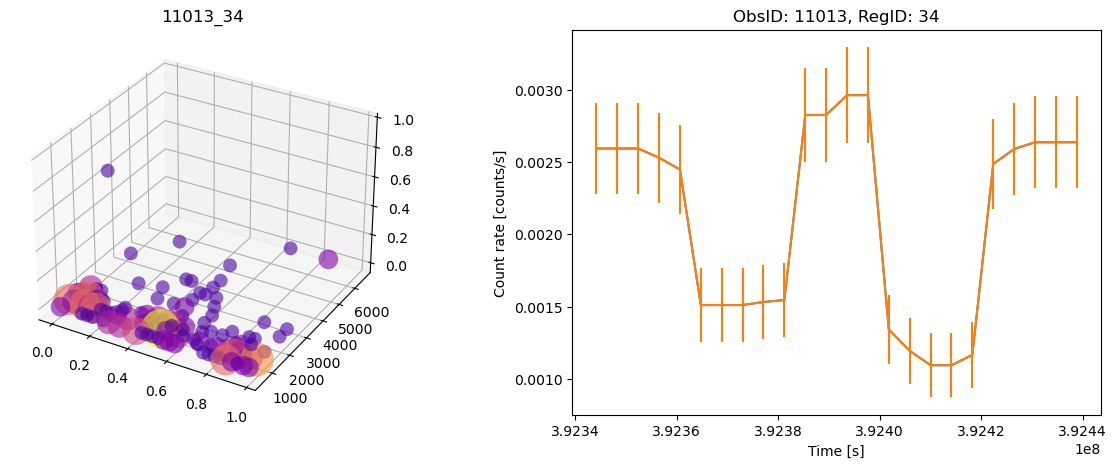

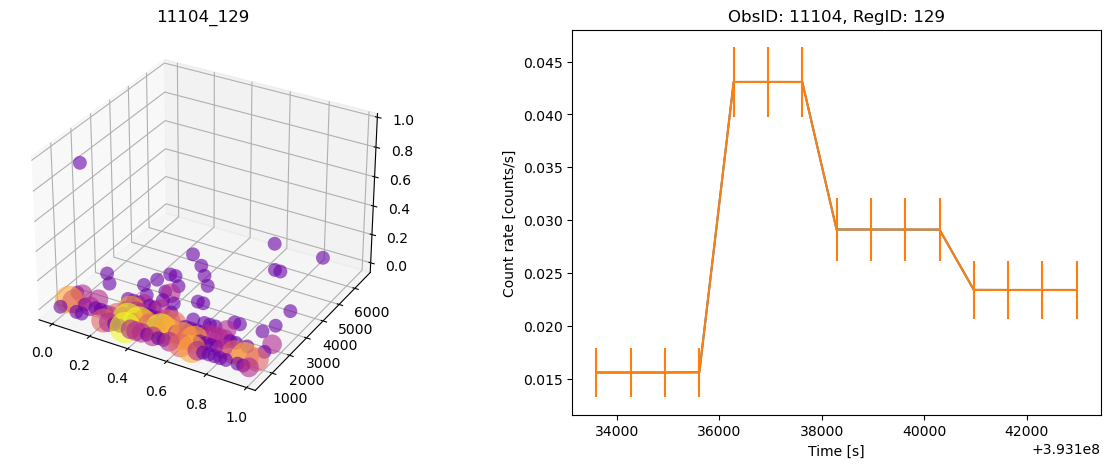

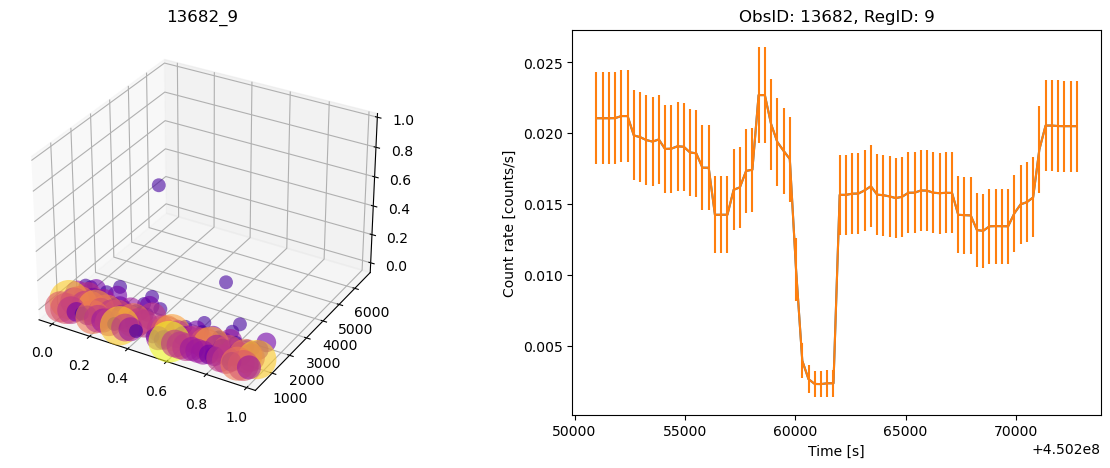

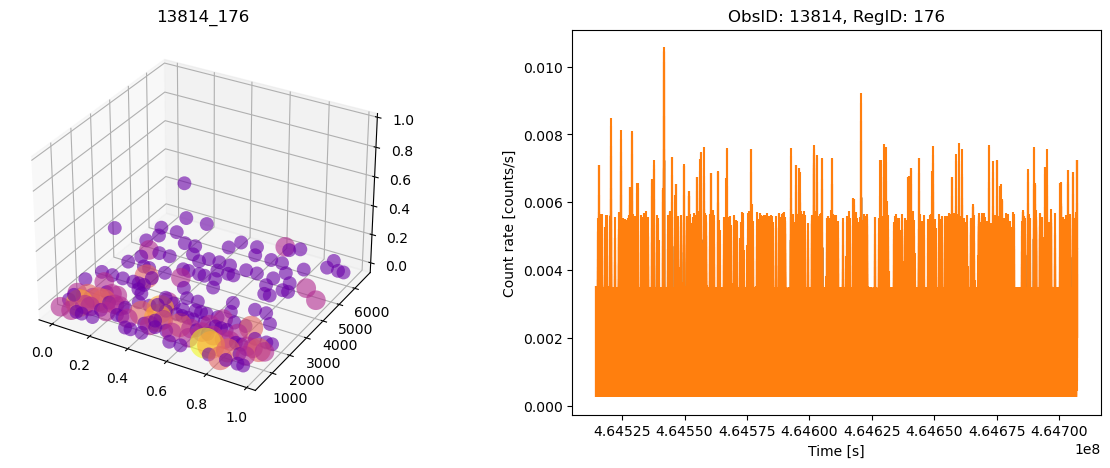

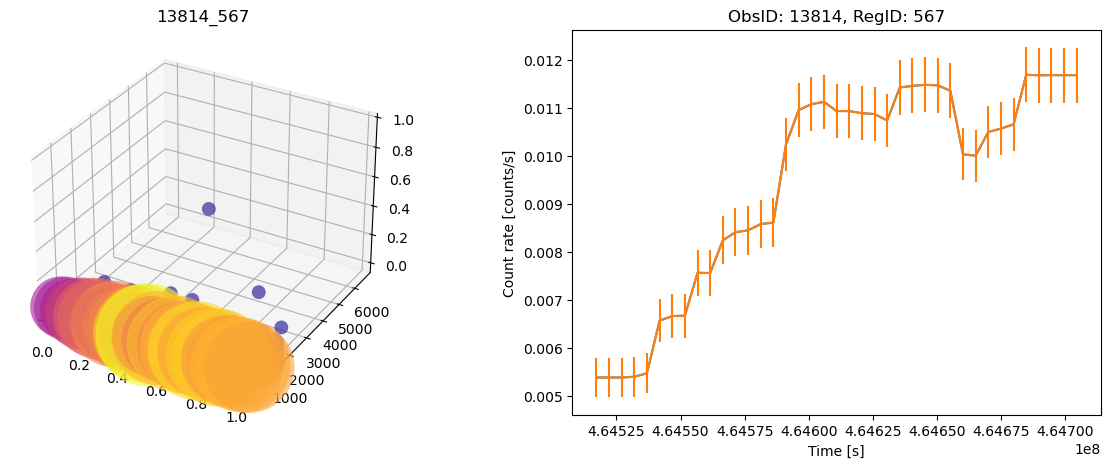

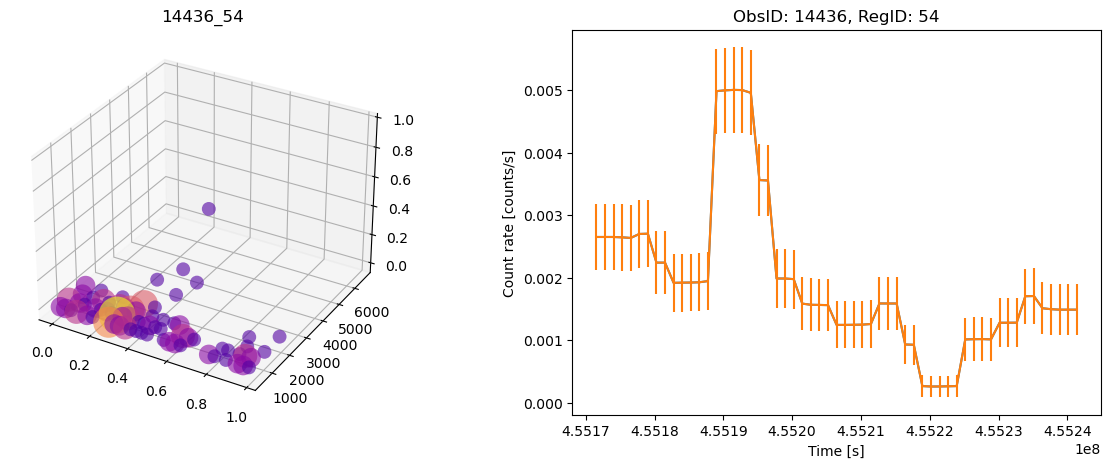

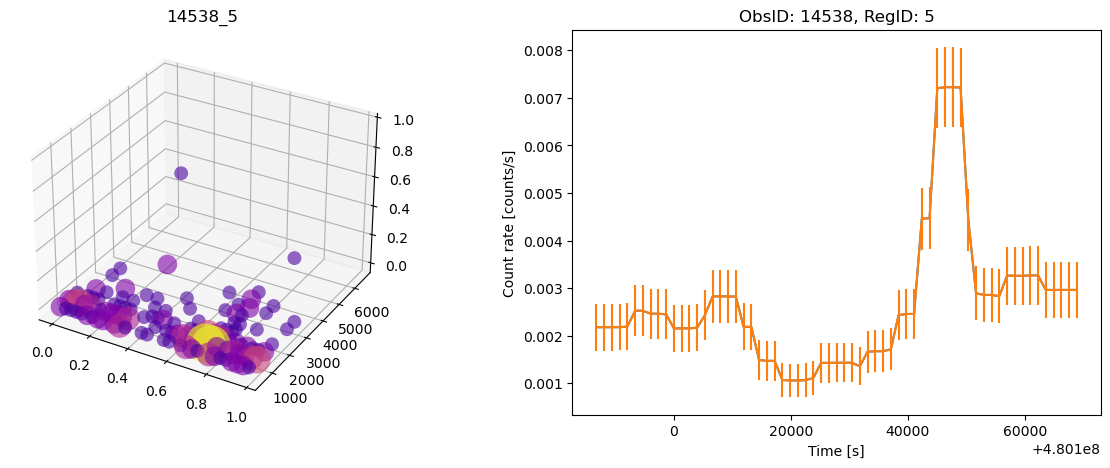

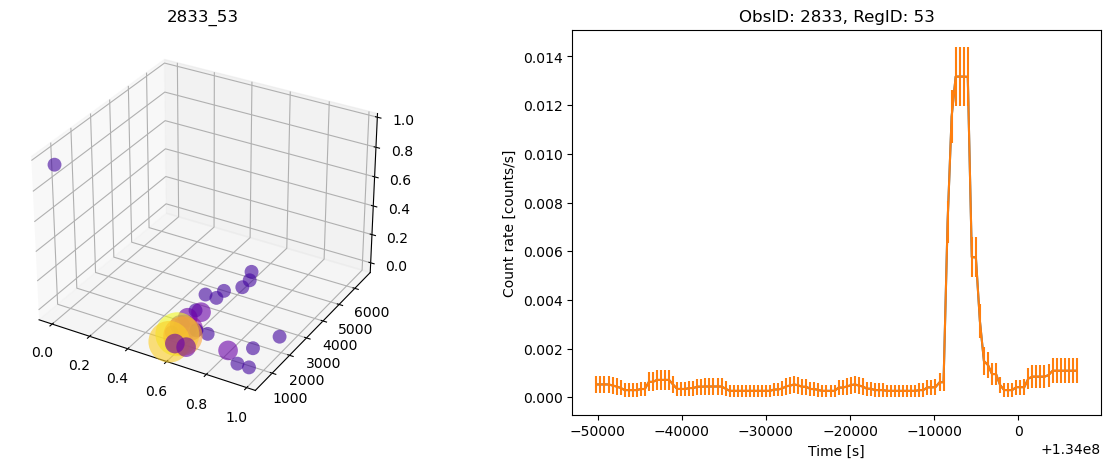

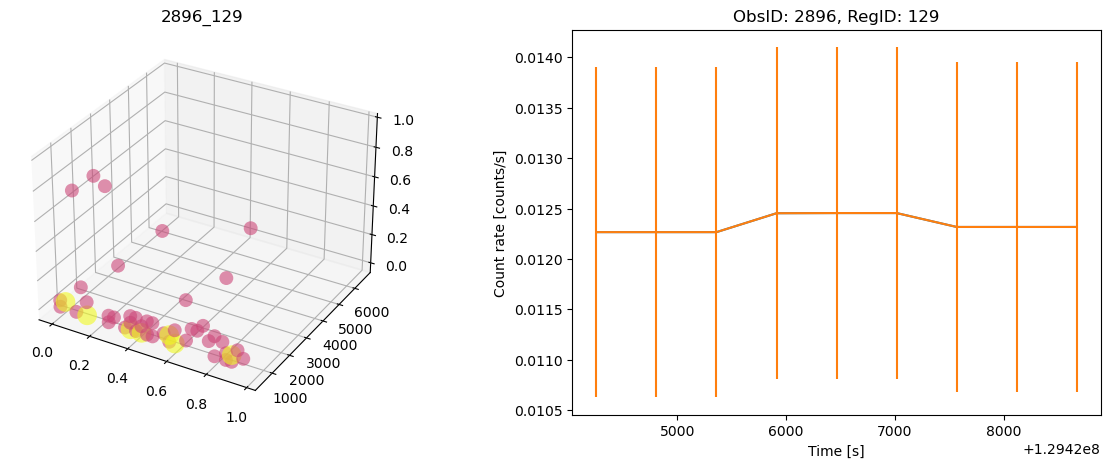

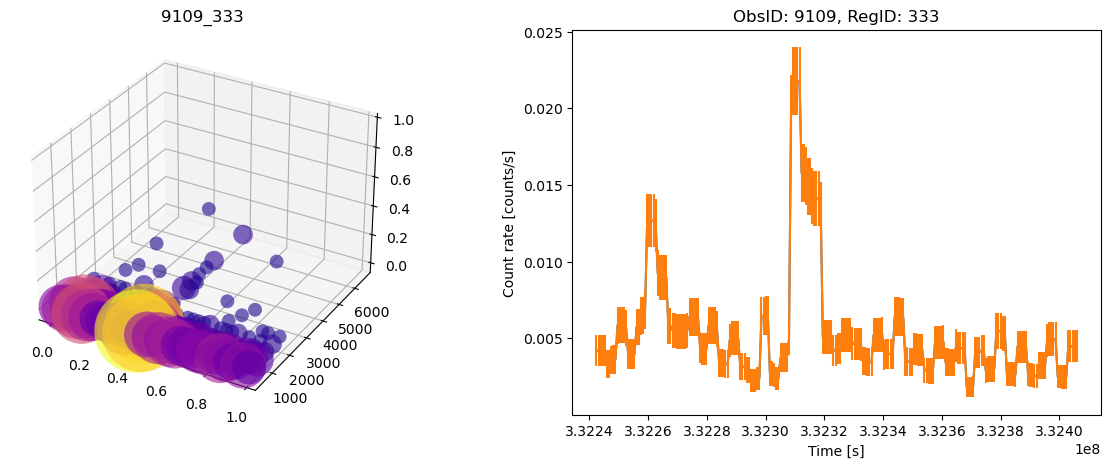

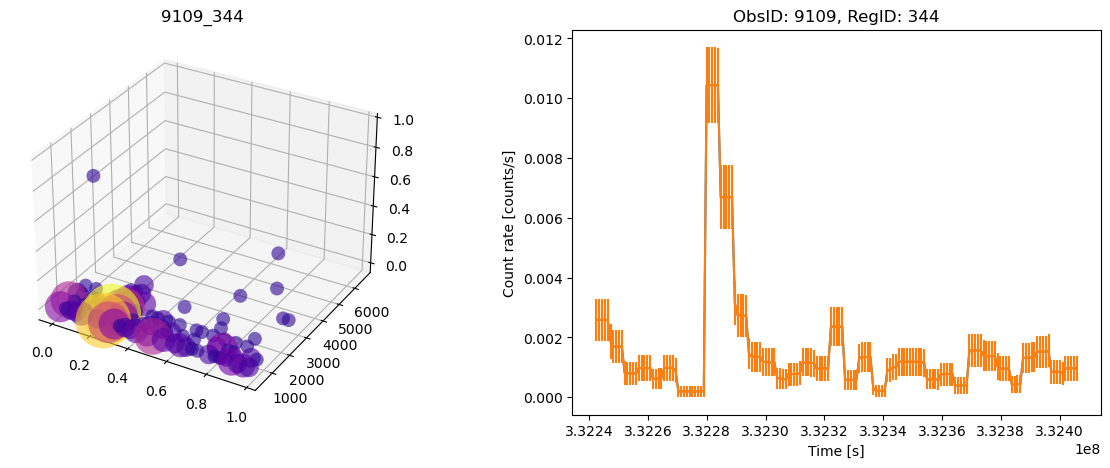

In [14]:
# Set ID
set_id = set_widget.value
#Settings
dt_axis_min = -4
dt_axis_max = 4

Emin = 0
Emax = 1

# nbins
nbins_dt50 = 10
nbins_E50 = 8
nbins_t50 = 20
nbins_dt75 = 16
nbins_E75 = 10
nbins_t75 = 26
nbins_dt90 = 22
nbins_E90 = 15
nbins_t90 = 35
nbins_dt95 = 26
nbins_E95 = 20
nbins_t95 = 45

# Define the number of bins for each dimension
xbins = nbins_t90
ybins = nbins_E90
zbins = nbins_dt90

# Loop over all eventfiles
for id_name, dfi in df_eventfiles_group:
    # Add delta_time column
    dfi["delta_time"] = dfi['time'].diff()
    # Remove first row as delta_time = nan
    dfi = dfi[dfi["delta_time"].notna()]
    # Add a constant value "pseudo-count" 0.1 to delta_time = 0 
    dfi["delta_time"] = dfi["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.1, dt))
    # Eventfile length and duration for normalisation
    N = len(dfi) 
    T = max(dfi["time"])-min(dfi["time"])
    # Add dt column (with normalisations applied)
    dfi["dt"] = np.exp((N * dfi["delta_time"]/T))
    dt_min = min(dfi["dt"])
    dt_max = max(dfi["dt"])
    dfi["dt"] = (dfi["dt"]- dt_min)/(dt_max-dt_min)
    # Add t column
    #dfi["t"] = np.log10((dfi["time"]-min(dfi["time"]))*N/T+0.0001)
    dfi["t"] = (dfi["time"]-min(dfi["time"]))/T
    t_min = min(dfi["t"])
    t_max = max(dfi["t"])
    # dfi["t"] = (dfi["t"]- t_min)/(t_max-t_min)
    # Add E column
    # dfi["E"] = 10**(dfi["energy"])
    dfi["E"] = dfi["energy"]
    E_min = min(dfi["E"])
    E_max = max(dfi["E"])
    # dfi["E"] = (dfi["E"]- E_min)/(E_max-E_min)
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]

    # # Create histogram representation
    # fig, (hist_Edt, hist_Et, hist_dtt) = plt.subplots(figsize=(8,8))
    # #hist = plt.hist2d(df["dt"],df["E"],range = [[dt_axis_min, dt_axis_max],[np.log10(500.), np.log10(7000.)]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma', density = True) 
    # hist_Edt = plt.hist2d(df["dt"],df["E"],range = [[dt_axis_min, dt_axis_max],[np.log10(500.), np.log10(7000.)]],bins=(nbins_dt,nbins_E),norm=LogNorm(),cmap = 'plasma')
    # hist_Et = plt.hist2d(df["t"],df["E"],range = [[0,1],[np.log10(500.), np.log10(7000.)]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    # hist_dtt = plt.hist2d(df["t"],df["dt"],range = [[0,1],[dt_axis_min, dt_axis_max]],bins=(nbins_t,nbins_dt),norm=LogNorm(),cmap = 'plasma') 

    # Compute the 3D histogram using numpy.histogramdd()
    hist3D, edges = np.histogramdd((dfi["t"], dfi["E"], dfi["dt"]), bins=(xbins, ybins, zbins),range=[(0,1),(500,7000),(0,1)])

    # Create a 3D scatter plot of the original data points
    fig = plt.figure(figsize=(15,5))
    ax3d = fig.add_subplot(121, projection='3d')
    # ax.scatter(dt, E, t, s=1, c=E, cmap='viridis', alpha=0.5)

    # Create a 3D histogram plot using matplotlib.pyplot.scatter()
    x, y, z = np.meshgrid(edges[0][:-1], edges[1][:-1], edges[2][:-1], indexing='ij')
    x = np.ravel(x)
    y = np.ravel(y)
    z = np.ravel(z)
    h = np.ravel(hist3D)

    ax3d.scatter(x, y, z, s=h*100, alpha=0.6, edgecolors='none', c=h, cmap='plasma')
    ax3d.set_title(id_name)

    axlc = fig.add_subplot(122)
    lc_filename = [lcurve for lcurve in glob.iglob(f'{global_path}/{set_id}/eventdata/acisf*lc3.fits.gz') if str(obsid) in lcurve and str(regid) in lcurve][0]
    pha_filename = [spec for spec in glob.iglob(f'{global_path}/{set_id}/eventdata/acisf*pha3.fits.gz') if str(obsid) in spec and str(regid) in spec][0]
    with fits.open(lc_filename) as hdul_lc:
        lc3 = hdul_lc[1].data
        bg3 = hdul_lc[2].data
        axlc.plot(lc3['Time'],lc3['COUNT_RATE'])
        axlc.set_xlabel('Time [s]')
        axlc.set_ylabel('Count rate [counts/s]')
        axlc.set_title(f'ObsID: {obsid}, RegID: {regid}')
        axlc.errorbar(lc3['Time'],lc3['COUNT_RATE'],lc3['COUNT_RATE_ERR'])

    plt.show()
    